# Credit Card Fraud Detection Predictive Model

Credit card fraud is a major concern in the financial industry nowadays. Analysing fraudulent transactions manually is unfeasible due to huge amounts of data and its complexity. However, given sufficiently informative features, one could expect it is possible to do using Machine Learning.

## Data Description

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.It contains only numerical input variables which are the result of a PCA transformation. Due to confidentiality issues, there are not provided the original features and more background information about the data.

* Features V1, V2, ... V28 are the principal components obtained with PCA;
* The only features which have not been transformed with PCA are Time and Amount. Feature Time contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature Amount is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.
* Feature Class is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Exploratory Data Analysis and Data Cleaning

In [54]:
# Loading the required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,roc_auc_score,recall_score,accuracy_score,precision_score

import warnings
warnings.filterwarnings('ignore')

### Checking the data

In [55]:
df=pd.read_csv('creditcard.csv')
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [57]:
values=df['Class'].value_counts()
values

0    284315
1       492
Name: Class, dtype: int64

Text(0.5, 1.0, 'Number of Class Labels')

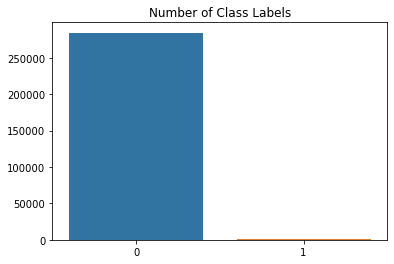

In [58]:
f1 = sns.barplot(values.index,values.values)
plt.title("Number of Class Labels")


The dataset is clearly unbalanced. This extreme unbalancing may cause to obtain over 99 % accuracy even if the model is a simple null classifier which always predict Class as 0. Means, it is insensitive towards false negatives. So measuring the model with accuracy score should not be used here. Rather, the most appropriate performance measures for this task are 

* precision
* recall
* f1 score
* AUC 

However, it is preferred to deal with this imbalanced dataset also by using appropriate sampling methods to make it balanced. SMOTE (Synthetic Minority Over-sampling Technique) method is used here.

Before balancing the dataset, some explorations can be done on the real dataset, to get more insights. 

### Data Exploration

**Transactions Time density plot**

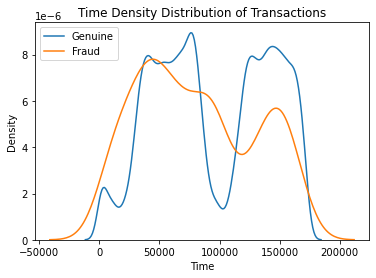

In [59]:
class_0 = df.loc[df['Class'] == 0]["Time"] # Fraud transactions
class_1 = df.loc[df['Class'] == 1]["Time"] # Genuine transactions
f1=sns.distplot(class_0,kde=True,hist=False,label='Genuine')
f2=sns.distplot(class_1,kde=True,hist=False,label='Fraud')
plt.legend()
plt.title('Time Density Distribution of Transactions')
plt.show()

From the time density plot, it can be concluded that the fraudulent transactions are distributed more evenly, compared to the genuine transactions. 

In [60]:
# Converting the time into hours, like 0 th hour, 1 st hr, 2nd hr etc.
df_sub = df[['Time','Class','Amount']]
df_sub['Hour']=df_sub['Time'].apply(lambda x: np.floor(x/3600))
df_amount = df_sub.groupby(['Hour','Class'])['Amount'].agg(['mean','max','min','sum','count']).reset_index()
df_amount.head()

,Hour,Class,mean,max,min,sum,count
0,0.0,0,64.774772,7712.43,0.0,256572.87,3961
1,0.0,1,264.500000,529.00,0.0,529.00,2
2,1.0,0,65.826980,1769.69,0.0,145806.76,2215
3,1.0,1,149.465000,239.93,59.0,298.93,2
4,2.0,0,68.803466,4002.88,0.0,106989.39,1555


**Total Amount Transacted**

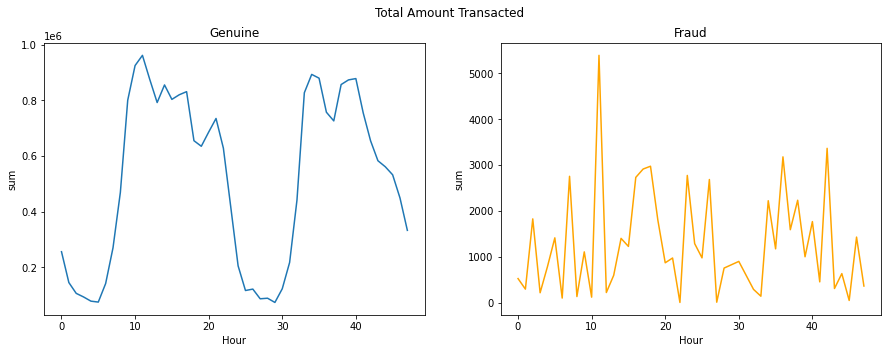

In [61]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,5))
f=sns.lineplot(ax=ax1,data=df_amount.loc[df_amount['Class']==0], x='Hour',y='sum')
f=sns.lineplot(ax=ax2,data=df_amount.loc[df_amount['Class']==1], x='Hour',y='sum',color='orange')
ax1.title.set_text("Genuine")
ax2.title.set_text("Fraud")
plt.suptitle("Total Amount Transacted")
plt.show()

**Average Amount of Transactions**

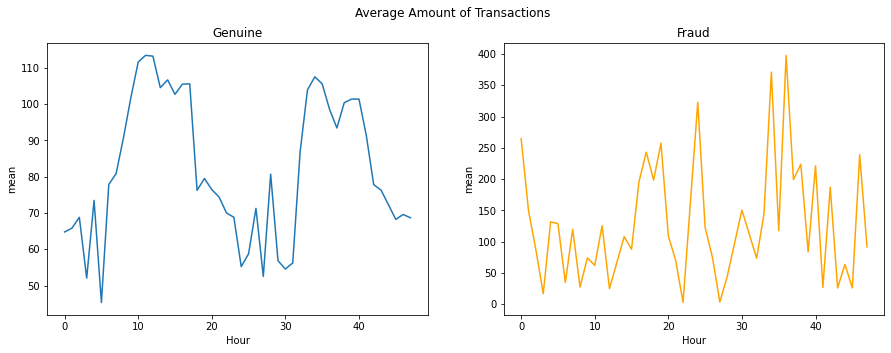

In [62]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,5))
f=sns.lineplot(ax=ax1,data=df_amount.loc[df_amount['Class']==0], x='Hour',y='mean')
f=sns.lineplot(ax=ax2,data=df_amount.loc[df_amount['Class']==1], x='Hour',y='mean',color='orange')
ax1.title.set_text("Genuine")
ax2.title.set_text("Fraud")
plt.suptitle("Average Amount of Transactions")
plt.show()

**Some other statistics**

In [63]:
df[df['Class']==0]['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [64]:
df[df['Class']==0]['Amount'].median()

22.0

In [65]:
df[df['Class']==1]['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [66]:
df[df['Class']==1]['Amount'].median()

9.25

Fraud transactions have high mean value of amount transferred compared to the genuine transactions. So the 'Amount' feature will be useful in predicting the class. However, the median is higher for the genuine ones, meaning the distribution of values for class “0” is left-skewed.

### Features Correlation

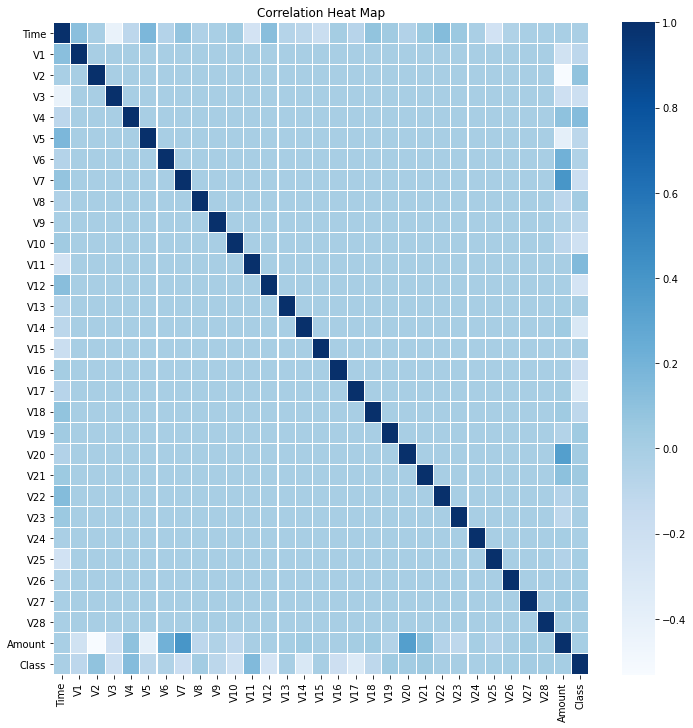

In [67]:
correlation = df.corr()
plt.figure(figsize = (12,12))
sns.heatmap(correlation,cmap='Blues',linewidths=0.1)
plt.title("Correlation Heat Map")
plt.show()

Negative or inverse correlation with time : V25,V11,V3
Positive correlation with time : V22,V18,V16,V12,V7,V5,V1 BUT NOT MUCH VISIBLE CORRELATION 
Negative correlation with Amount : V2,V5
Positive correlation with Amount : v4,v6,v7,v20

Time and Amount has no correlation with class.
v2,v4,v11 have positive correlation with class

There are no correlations in between v1 to v28 variables

### Model Development

The data is highly imbalanced. This should be balanced before modeling.
over sampling, under sampling, etc. Out of the available methods, use SMOTE 

(SMOTE has been shown to perform better classification performance in the ROC space than either over- or undersampling (From Nitesh V. Chawla, Kevin W. Bowyer, Lawrence O. Hall and W. Philip Kegelmeyer’s “SMOTE: Synthetic Minority Over-sampling Technique” (Journal of Artificial Intelligence Research, 2002, Vol. 16, pp. 321–357)). Since ROC is the measure we are going to optimize for, we will use SMOTE to resample the data)

In [68]:
sampling_model = SMOTE() # SMOTE Sampling method
X_resampled,y_resampled = sampling_model.fit_resample(df,df['Class']) # output the resampled predictors and target value
fraud = y_resampled[~(y_resampled == 1)] # fraud values after resampling
len(fraud)

284315

In [69]:
X = X_resampled.drop('Class',axis=1)
y = y_resampled
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [70]:
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred)
print(f' accuracy = {accuracy}\n recall = {recall}, \n precision = {prec}, \n auc score = {auc}')

 accuracy = 0.9714402284781721
 recall = 0.9633041695338942, 
 precision = 0.9793406718921774, 
 auc score = 0.9714549064326037


The simple Logistic Regression is enough to give best results